In [35]:
from netCDF4 import Dataset
import numpy as np
from math import sin, cos, radians, sqrt
import pandas as pd
import matplotlib.pyplot as plt
from cartoplot import cartoplot
import pickle
from regrid import regrid
from field_importer import get_field
import xarray as xr
import mask
import os
import subprocess

# Average the daily data

In [ ]:
directory = '/media/robbie/Seagate Portable Drive/OSISAF_data_big'
destination = '/media/robbie/Seagate Portable Drive/OSISAF_data_big/Monthly_means'

# First iterate through the years where OSISAF data is available

for subdir in os.listdir(directory):
    
    # Print the year
    
    print(subdir)
    
    # One directory doesn't correspond to a year, but instead to monthly means. Ignore thyis
    
    if subdir == '2009':
        
        # For a given year, iterate through the months inside
        
        for monthdir in os.listdir(directory + '/' + subdir):
            
#             Print the month name

            if int(monthdir) > 4:

                print(monthdir)

    #             Choose the month name

                os.chdir(directory + '/' + subdir + '/' + monthdir)

                # This puts all the netcdfs into one, daily file

                p = subprocess.Popen(['cdo', 'mergetime', '*.nc', 'timeseries.nc' ])

                p.wait()

                # This averages that single daily file into a new monthly mean file

                p = subprocess.Popen(['cdo', 'monmean', 'timeseries.nc', f'{subdir}_{monthdir}_monthlymean.nc'])

                p.wait()

                # This moves that monthly mean file into a new destination folder where all the means can be analysed

    #             p = subprocess.Popen(['cp', subdir+'/'monthdir+'monthlymean.nc', destination])

    #             p.wait()

# Regrid to 361x361 for compatability with SnowModel output

In [ ]:
yearlist = list(range(2005,2019))

monthlist_full = ["01","02","03","04","10","11","12"]
monthlist_start = ["03","10","11","12"]

W99_OSISAF = {"depth":{},"density":{},"SWE":{}}

lon_target, lat_target = mask.get('lon'),mask.get('lat')

for year in yearlist:
    
    if year == 2005:
        monthlist = monthlist_start
    else:
        monthlist = monthlist_full
    
    for month in monthlist:
        
        data = get_field('osisaf',month,year,variable=None,resolution=760)
        
        data_361 = regrid(data['field'],data['lon'],data['lat'],lon_target,lat_target)
        
        output = {'field':data_361,'lon':lon_target,'lat':lat_target}
        
        att_dict = {'title': 'Monthly sea ice type data regridded on 361x361 EASE grid',
                    'month': f'{month}',
                    'year':f'{year}'}
        
        ds = xarray.Dataset( data_vars={'ice_type':(['x','y'],output['field'])},
                             coords={'lon':(['x','y'],output['lon']),
                                     'lat':(['x','y'],output['lat'])},
                             attrs=att_dict)
        
        ds.to_netcdf(f'/home/robbie/Dropbox/SM_Thickness/data/OSISAF_type_monthlies/361/{year}{month}monmean.nc','w')

In [19]:
monthlist_full = ["01","02","03","04","10","11","12"]
monthlist_ints = []

for i in monthlist_full:
    monthlist_ints.append(int(i))
    
grid_res = (1120, 760)
    
array = np.full((grid_res[0],grid_res[1],len(monthlist_ints)), np.nan)

year = 2007


for count, month in enumerate(monthlist_full):
    data = get_field('osisaf',month,year,variable='type')
    field, lon, lat = data['field'], data['lon'], data['lat']
    array[:,:,count] = field

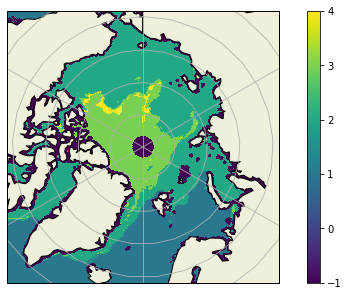

PermissionError: [Errno 13] Permission denied: b'/home/robbie/Dropbox/SM_Thickness/code/2007_ice_types.nc'

In [63]:
cartoplot(lon, lat, array[:,:,0])


ds = xarray.Dataset( data_vars={'ice_type':(['x','y','t'],array)},
                     coords={'lon':(['x','y'],lon),
                             'lat':(['x','y'],lat),
                             'mon':(['t'],monthlist_ints)})

ds.to_netcdf(f'2007_ice_types.nc','w')

In [65]:
data = Dataset('2007_ice_types.nc')
print(data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): x(1120), y(760), m(7)
    variables(dimensions): float64 ice_type(x,y,m), float32 lon(x,y), float32 lat(x,y), int64 mon(m)
    groups: 


In [67]:
ds = xr.open_dataset('2007_ice_types.nc')

ds2 = ds.where(10 == ds.mon, drop=True)

print(ds2)

<xarray.Dataset>
Dimensions:   (m: 1, x: 1120, y: 760)
Coordinates:
    lon       (x, y) float32 168.33801 168.26953 ... -10.0547695 -9.982807
    lat       (x, y) float32 31.029392 31.068121 ... 34.43777 34.396038
    mon       (m) int64 10
Dimensions without coordinates: m, x, y
Data variables:
    ice_type  (x, y, m) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
<bound method Mapping.values of <xarray.Dataset>
Dimensions:   (m: 1, x: 1120, y: 760)
Coordinates:
    lon       (x, y) float32 168.33801 168.26953 ... -10.0547695 -9.982807
    lat       (x, y) float32 31.029392 31.068121 ... 34.43777 34.396038
    mon       (m) int64 10
Dimensions without coordinates: m, x, y
Data variables:
    ice_type  (x, y, m) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0>


In [62]:
ds = xr.open_dataset('2007_ice_types.nc')

print(ds)

ds2 = ds.sel(mon>5)

<xarray.Dataset>
Dimensions:   (m: 7, x: 1120, y: 760)
Coordinates:
    lon       (x, y) float32 ...
    lat       (x, y) float32 ...
    mon       (m) int64 ...
Dimensions without coordinates: m, x, y
Data variables:
    ice_type  (x, y, m) float64 ...


NameError: name 'mon' is not defined